In [86]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten,add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from keras.layers import merge
from keras.layers import concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
import nltk

In [3]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [4]:
captions = open(token, 'r').read().strip().split('\n')

In [5]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [6]:
d = {}
for i, row in enumerate(captions):
    #print(i)
    row = row.split('\t')
    
    row[0] = row[0][:len(row[0])-2]
    #print(row[0])
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [7]:
d

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [8]:

d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
images = 'Flicker8k_Dataset/'

In [10]:
len(images)

18

In [11]:
import os
p=os.path.join(images,'*.jpg')
# Contains all the images
img= glob.glob(p)
img=[item.replace("\\", "/") for item in img]

In [12]:

img[:5]

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset/1003163366_44323f5815.jpg',
 'Flicker8k_Dataset/1007129816_e794419615.jpg']

In [13]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [14]:

train_images = (open(train_images_file, 'r').read().strip().split('\n'))

In [15]:
len(train_images)

6000

In [16]:
def split_data(l):
    temp = []
    for i in img:
        #print(i)
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [17]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [18]:
train_img

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset/1003163366_44323f5815.jpg',
 'Flicker8k_Dataset/1007129816_e794419615.jpg',
 'Flicker8k_Dataset/1007320043_627395c3d8.jpg',
 'Flicker8k_Dataset/1009434119_febe49276a.jpg',
 'Flicker8k_Dataset/1012212859_01547e3f17.jpg',
 'Flicker8k_Dataset/1015118661_980735411b.jpg',
 'Flicker8k_Dataset/1015584366_dfcec3c85a.jpg',
 'Flicker8k_Dataset/101654506_8eb26cfb60.jpg',
 'Flicker8k_Dataset/101669240_b2d3e7f17b.jpg',
 'Flicker8k_Dataset/1016887272_03199f49c4.jpg',
 'Flicker8k_Dataset/1019077836_6fc9b15408.jpg',
 'Flicker8k_Dataset/1019604187_d087bf9a5f.jpg',
 'Flicker8k_Dataset/1020651753_06077ec457.jpg',
 'Flicker8k_Dataset/1022454428_b6b660a67b.jpg',
 'Flicker8k_Dataset/1022975728_75515238d8.jpg',
 'Flicker8k_Dataset/102351840_323e3de834.jpg',
 'Flicker8k_Dataset/1024138940_f1fefbdce1.jpg',
 'Flicker8k_Dataset/102455176_5f8ead62d5.jp

In [19]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [20]:

# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [21]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [22]:

# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

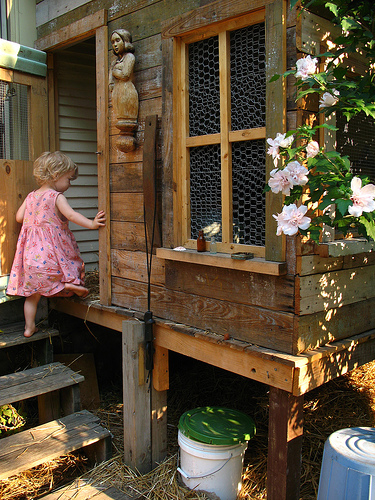

In [23]:
Image.open(train_img[0])

In [24]:

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [25]:

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

W1219 10:14:19.834457  4752 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


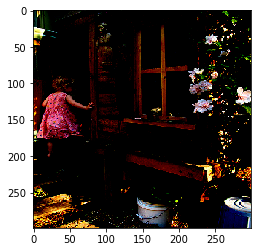

In [26]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [27]:

model = InceptionV3(weights='imagenet')

W1219 10:14:31.425732  4752 deprecation.py:506] From C:\Users\Srinivas\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [2]:
import keras
keras.__version__

'2.0.5'

In [277]:
import tensorflow
tensorflow.__version__

'1.14.0'

In [29]:
tryi = model_new.predict(preprocess(train_img[0]))

In [30]:
tryi.shape

(1, 2048)

In [31]:

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [106]:

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

In [107]:
encoding_train

{'1000268201_693b08cb0e.jpg': array([0.12277618, 0.3329493 , 0.7527168 , ..., 0.21939708, 0.30216393,
        0.4028318 ], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([0.7366835 , 0.5911323 , 0.18194222, ..., 0.16030245, 0.34144688,
        0.9083169 ], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([0.3735191 , 0.24596632, 0.9635304 , ..., 1.1459357 , 0.26540142,
        0.01983142], dtype=float32),
 '1003163366_44323f5815.jpg': array([0.48603088, 0.2921827 , 0.31436834, ..., 0.98254853, 0.28108057,
        0.22330025], dtype=float32),
 '1007129816_e794419615.jpg': array([0.21595323, 0.15582061, 0.29477087, ..., 0.40564936, 0.16532063,
        0.37416944], dtype=float32),
 '1007320043_627395c3d8.jpg': array([0.17231001, 0.49808335, 0.21576989, ..., 0.09676232, 1.2298493 ,
        0.5421422 ], dtype=float32),
 '1009434119_febe49276a.jpg': array([0.5346086 , 1.3676211 , 0.78043544, ..., 0.39463788, 0.88772327,
        1.0728819 ], dtype=float32),
 '1012212859_01547e3f17.jpg

In [111]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [32]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [176]:
# Call the funtion to encode all the test images - Execute this only once
#start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

In [ ]:
encoding_test

In [113]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [33]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [34]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [35]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [36]:

len(train_d)

6000

In [37]:
train_d

{'Flicker8k_Dataset/1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in

In [38]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [39]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [40]:
val_d

{'Flicker8k_Dataset/1022454332_6af2c1449a.jpg': ['A child and a woman are at waters edge in a big city .',
  'a large lake with a lone duck swimming in it with several people around the edge of it .',
  'A little boy at a lake watching a duck .',
  'A young boy waves his hand at the duck in the water surrounded by a green park .',
  'Two people are at the edge of a lake , facing the water and the city skyline .'],
 'Flicker8k_Dataset/103106960_e8a41d64f8.jpg': ['A boy with a stick kneeling in front of a goalie net',
  'A child in a red jacket playing street hockey guarding a goal .',
  'A young kid playing the goalie in a hockey rink .',
  'A young male kneeling in front of a hockey goal with a hockey stick in his right hand .',
  'Hockey goalie boy in red jacket crouches by goal , with stick .'],
 'Flicker8k_Dataset/1032122270_ea6f0beedb.jpg': ['A woman crouches near three dogs in a field .',
  'Three dogs are playing on grassy hill with a blue sky .',
  'Three dogs are standing in th

In [41]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [42]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [43]:

words = [i.split() for i in caps]

In [44]:
unique = []
for i in words:
    unique.extend(i)

In [45]:

unique = list(set(unique))

In [182]:
with open("unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d)

In [46]:

unique = pickle.load(open('unique.p', 'rb'))

In [47]:
len(unique)

8256

In [48]:
word2idx = {val:index for index, val in enumerate(unique)}

In [49]:

word2idx['<start>']

2746

In [50]:
idx2word = {index:val for index, val in enumerate(unique)}

In [51]:

idx2word[5553]

'shots'

In [52]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [53]:

len(unique), max_len

(8256, 40)

In [54]:
vocab_size = len(unique)

In [55]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [56]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [57]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [58]:
c = [i for i in df['captions']]
len(c)

30000

In [59]:
imgs = [i for i in df['image_id']]

In [60]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [61]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 2746
Woman => 7931
writing => 6568
on => 1524
a => 6969
pad => 2568
in => 4934
room => 6034
with => 4482
gold => 367
, => 7926
decorated => 2693
walls => 1125
. => 5080
<end> => 572


In [62]:

samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [63]:

samples_per_epoch

383454

In [64]:

def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [65]:

embedding_size = 300

In [66]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [82]:
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
        
image_model.add(RepeatVector(max_len))

In [249]:
image_model

In [67]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

W1219 10:17:27.197250  4752 deprecation.py:506] From C:\Users\Srinivas\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [83]:
caption_model = Sequential()
caption_model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
caption_model.add(LSTM(256, return_sequences=True))
caption_model.add(TimeDistributed(Dense(300)))

In [97]:
model_combined=Sequential()
model_combined
model_combined.add(Merge([image_model, caption_model],mode='concat'))

model_combined.add(Bidirectional(LSTM(256, return_sequences=False)))
model_combined.add(Dense(vocab_size))
model_combined.add(Activation('softmax'))

C:\Users\Srinivas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


AttributeError: 'Node' object has no attribute 'output_masks'

In [94]:

final_model = Sequential([
        Concatenate(axis=-1)([image_model, caption_model]),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

ValueError: Layer concatenate_5 was called with an input that isn't a symbolic tensor. Received type: <class 'tensorflow.python.keras.engine.sequential.Sequential'>. Full input: [<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000004B6DAAA128>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000004B6FFCDF28>]. All inputs to the layer should be tensors.

In [194]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_d.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000